# Corsair Data Analytics On Amazon Reviews

In [156]:
import numpy as np
import pandas as pd
import seaborn as sns

from collections import Counter
from wordcloud import WordCloud

from matplotlib import pyplot as plt
from pandarallel import pandarallel

from reviews.config import processed_data_dir

pandarallel.initialize(progress_bar=False, nb_workers=8)

INFO: Pandarallel will run on 8 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


### Read Data

In [157]:
data_df = pd.read_json(processed_data_dir / "products_reviews.json.gz")

data_df["asin"] = data_df["asin"].astype("category")
data_df["text"] = data_df["text"].astype("string")
data_df["summary"] = data_df["summary"].astype("string")
data_df["overall"] = data_df["overall"].astype("category")
data_df["brand"] = data_df["brand"].astype("category")
data_df["category"] = data_df["category"].astype("category")
data_df["description"] = data_df["description"].astype("string")
data_df["title"] = data_df["title"].astype("string")

data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21954 entries, 0 to 21953
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   asin             21954 non-null  category      
 1   overall          21954 non-null  category      
 2   reviewerID       21954 non-null  object        
 3   summary          21954 non-null  string        
 4   text             21954 non-null  string        
 5   timestamp        21954 non-null  datetime64[ns]
 6   vote             21954 non-null  int64         
 7   brand            21954 non-null  category      
 8   category         21954 non-null  category      
 9   description      21447 non-null  string        
 10  imageURLHighRes  18021 non-null  object        
 11  price            21954 non-null  float64       
 12  title            21954 non-null  string        
dtypes: category(4), datetime64[ns](1), float64(1), int64(1), object(2), string(4)
memory usage:

In [158]:
data_df.head(5)

,asin,overall,reviewerID,summary,text,timestamp,vote,brand,category,description,imageURLHighRes,price,title
0,B0009PAZ0Q,5,A2SOTPCGTVXK72,"good product, I recommend it","good product, I recommend it, that card looks ...",2013-06-24,0,corsair,Memory,Are you looking for a performance upgrade for ...,https://images-na.ssl-images-amazon.com/images...,1.54,Corsair 1GB (1x1GB) DDR2 533 MHz (PC2 4200) La...
1,B007V4DSJS,5,A2ZGN3FCLSMQUX,After one incorrect order for memory for this ...,After one incorrect order for memory for this ...,2014-10-15,0,komputerbay,Memory,"While at first glance, it may be in your best ...",None,5.35,Komputerbay 8GB (2 X 4GB) DDR2 DIMM (240 pin) ...
2,B005B0A6ZS,5,A1J5IZ8E767S1B,It does what I need: makes more ATA ports ...,It does what I need: makes more ATA ports ava...,2015-10-30,0,io crest,I/O Port Cards,The IO Crest 2 Port SATA III 6Gbps PCI-Express...,https://images-na.ssl-images-amazon.com/images...,14.59,IO Crest 2-port SATA III PCIe 2.0 x2 Controlle...
3,B00MMLXIKY,2,A32LLIL80MJ314,Two Stars,Underwhelming.,2016-03-20,0,intel,CPU Processors,"With faster, intelligent, multi-core technolog...",https://images-na.ssl-images-amazon.com/images...,7.80,Intel Core i7-5820K Desktop Processor (6-Cores...
4,B00F6S10KK,5,A3H5L8YVOFHSQ7,nice,great fans. nice lights.,2016-10-05,0,corsair,Fans & Cooling,Superior cooling performance and LED illuminat...,https://images-na.ssl-images-amazon.com/images...,2.54,Corsair Air Series AF120 LED Quiet Edition Hig...


### Select Corsair specific Data

In [159]:
corsair_df = data_df[data_df['brand'] == 'corsair']
corsair_df.head(5)

,asin,overall,reviewerID,summary,text,timestamp,vote,brand,category,description,imageURLHighRes,price,title
0,B0009PAZ0Q,5,A2SOTPCGTVXK72,"good product, I recommend it","good product, I recommend it, that card looks ...",2013-06-24,0,corsair,Memory,Are you looking for a performance upgrade for ...,https://images-na.ssl-images-amazon.com/images...,1.54,Corsair 1GB (1x1GB) DDR2 533 MHz (PC2 4200) La...
4,B00F6S10KK,5,A3H5L8YVOFHSQ7,nice,great fans. nice lights.,2016-10-05,0,corsair,Fans & Cooling,Superior cooling performance and LED illuminat...,https://images-na.ssl-images-amazon.com/images...,2.54,Corsair Air Series AF120 LED Quiet Edition Hig...
7,B0092ML0MY,4,A2D57GCLH76X9C,Just what you want from a PSU/ I have had good...,Plugged it in and it powered up. Just what you...,2017-04-30,0,corsair,Power Supplies,The Corsair Builder Series of PSUs are designe...,https://images-na.ssl-images-amazon.com/images...,4.16,Corsair CX Series 500 Watt 80 Plus Bronze Cert...
15,B006ON5KZC,5,A2EZBKKBVLNXQ4,Great RAM.,Works! Need I say more? Great RAM.,2016-04-06,0,corsair,Memory,"For Apple 2011 MacBook Pro, Mac Mini, and iMac...",None,3.55,Corsair Apple Certified 16GB (2 x 8GB) DDR3 13...
24,B00L64NSL2,5,A2QBYJBRC0TVLD,Keeps my case nice and cool with a little bit ...,Keeps my case nice and cool with a little bit ...,2017-04-11,0,corsair,Fans & Cooling,Corsair CO-9050032-WW SP120 Twin Dual Pack 120...,https://images-na.ssl-images-amazon.com/images...,2.54,Corsair Air Series SP 120 LED Green High Stat...


### Number of reviews for each reviewerID (to ensure that the reviews are not all from the same person)

In [215]:
'Number of unique reviwers: {}, Average Number of Reviews per single reviwer: {}'.format(corsair_df["reviewerID"].nunique(), corsair_df['reviewerID'].value_counts().mean())


'Number of unique reviwers: 2427, Average Number of Reviews per single reviwer: 1.0243098475484136'

### Number of Products Reviewed and total Number of Reviews

In [225]:
corsair_df["asin"] = corsair_df["asin"].astype("string").astype("category")

'Number of total Reviews: {}, Number of total Products Reviwed: {}, Mean Number of Reviews Per Product: {}' \
    .format(len(corsair_df), len(corsair_df["asin"].unique()), corsair_df['asin'].value_counts().mean())


'Number of total Reviews: 2486, Number of total Products Reviwed: 124, Mean Number of Reviews Per Product: 20.048387096774192'

### Reviews Over Time
- Looking the number of reviews over the years we can see the raising in the interest of people in ~2012 to ~2016 then decreasing until 2018
- Looking at how many reviews they have on average per week/month telling us how much the customers are active

In [162]:
period = 'M'
corsair_df["period"] = corsair_df["timestamp"].dt.to_period(period)
corsair_df["period"] = corsair_df["period"].dt.to_timestamp()

x = pd.DataFrame(corsair_df["period"].value_counts().reset_index().rename(columns={'index':'period', "period": "count"}))

import plotly.express as px

px.bar(x, x="period", y="count", color_discrete_sequence=['gray'])

/tmp/ipykernel_21365/3793263729.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_21365/3793263729.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### Reviews Ratings (how satisfied customers feel with our brand products)

Average Rating: 4.51


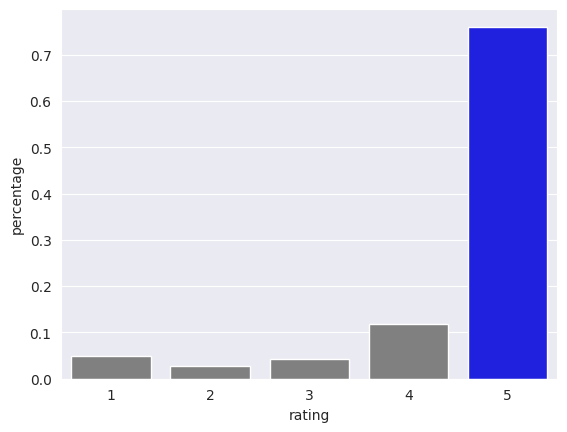

In [163]:
rating_df = corsair_df["overall"] \
    .value_counts(normalize=True) \
    .reset_index() \
    .rename(columns={'index':'rating', 'overall':'percentage'})

rating_df = pd.DataFrame(rating_df)
rating_df["rating"] = rating_df["rating"].astype("category")
rating_df['color'] = rating_df["rating"].apply(
    lambda x: "blue" if x == 5 else "gray"
)

barplot_palette = pd.DataFrame(rating_df.groupby(['rating', 'percentage'])['color'] \
    .value_counts()) \
    .rename(columns={'color':'count2'}) \
    .reset_index() \
    .sort_values(by='percentage')['color']

sns.barplot(rating_df, y='percentage', x='rating', palette=barplot_palette)


print("Average Rating: {:,.2f}".format(corsair_df["overall"].astype("float").mean()))

### Most Reviewed Categories (the main categories that our brand deals with)

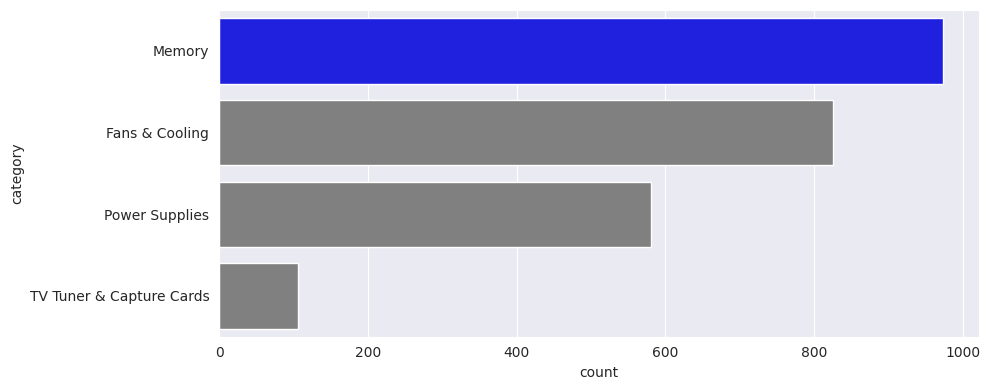

In [164]:
fig = plt.figure(figsize=(10, 4))

category_df = pd.DataFrame(corsair_df['category'] \
    .value_counts()) \
    .reset_index() \
    .rename(columns={'index':'category', 'category':'count'})

category_df[category_df["count"] <= 0] = np.nan
category_df.dropna(inplace=True)
category_df["category"] = category_df["category"].astype("category")
category_df["count"] = category_df["count"].astype("int")


category_df["color"] = category_df["count"].apply(
    lambda x: "blue" if x == category_df["count"].max() else "gray"
)

barplot_palette = pd.DataFrame(category_df.groupby(['category', 'count'])['color'] \
    .value_counts()) \
    .rename(columns={'color':'count2'}) \
    .reset_index() \
    .sort_values(by='count', ascending=False)['color']

ax = sns.barplot(category_df, x='count', y='category',
                order=category_df.sort_values(by='count', ascending=False)["category"], palette=barplot_palette)
fig.tight_layout()

plt.legend([],[], frameon=False)

### Number of Reviews per Price (telling us at what price people are more willing to buy)

In [165]:
price_categories = pd.CategoricalDtype(
    categories=[
        "Under \$25",
        "\$25 to \$50",
        "\$50 to \$100",
        "\$100 to \$200",
        "\$200 & Above",
    ],
    ordered=True,
)

corsair_df["price"] = corsair_df["price"].apply(
    lambda x: "Under \$25"
    if x < 25
    else (
        "\$25 to \$50"
        if x < 50
        else (
            "\$50 to \$100"
            if x < 100
            else ("\$100 to \$200" if x < 200 else "\$200 & Above")
        )
    )
)
corsair_df["price"] = corsair_df["price"].astype(price_categories)

/tmp/ipykernel_21365/2083052175.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_21365/2083052175.py:25: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



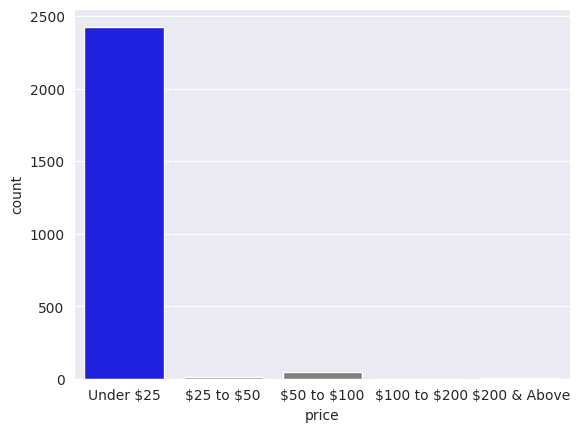

In [166]:
price_palette = []
categories=[
    "Under \$25",
    "\$25 to \$50",
    "\$50 to \$100",
    "\$100 to \$200",
    "\$200 & Above",
]
for x in categories:
    if x == "Under \$25":
        price_palette.append('blue')
    else:
        price_palette.append('gray')

ax = sns.countplot(corsair_df, x='price', palette=price_palette)
fig.tight_layout()

### Corsairs' competitors
- Most Reviewed Brands of the Memory Category
- Most Reviewed Brands of the Fans & Cooling Category
- Most Reviewed Brands of the Power Supplies Category
- Most Reviewed Brands of the TV Tuner & Capture Cards Category

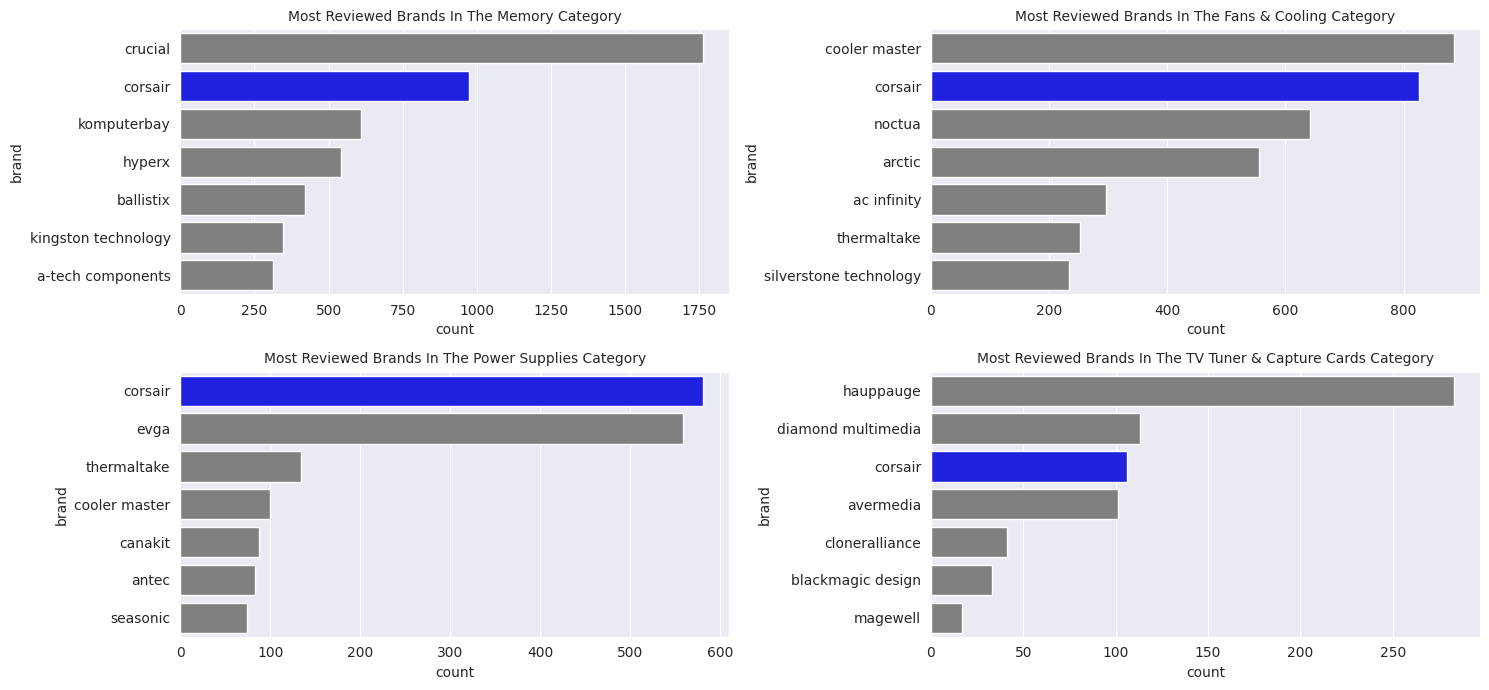

In [167]:
def competitors_by_category(data_df, category, ax):
    category_df = data_df[data_df['category'] == category]
    mc_category_brands_df = pd.DataFrame(Counter(category_df["brand"].tolist()).most_common(7)).reset_index().rename(columns={0:'brand', 1:'count'})

    mc_category_brands_df['color'] = mc_category_brands_df["brand"].apply(
        lambda x: "blue" if x == 'corsair' else "gray"
    )

    barplot_palette = pd.DataFrame(mc_category_brands_df.groupby(['brand', 'count'])['color'] \
        .value_counts()) \
        .rename(columns={'color':'count2'}) \
        .reset_index() \
        .sort_values(by='count', ascending=False)['color']

    plot = sns.barplot(mc_category_brands_df, x='count', y='brand',
                    order=mc_category_brands_df.sort_values(by='count', ascending=False)["brand"], palette=barplot_palette, ax=ax)
    plot.set_title(f'Most Reviewed Brands In The {category} Category', fontsize = 10)
    return plot

fig, axes = plt.subplots(2, 2, figsize=(15, 7))
axes = axes.flatten()
competitors_by_category(data_df, 'Memory', axes[0])
competitors_by_category(data_df, 'Fans & Cooling', axes[1])
competitors_by_category(data_df, 'Power Supplies', axes[2])
competitors_by_category(data_df, 'TV Tuner & Capture Cards', axes[3])
fig.tight_layout()

### Top 30 Most Common Votes (we can see how people usually don't vote on reviews or very few do)

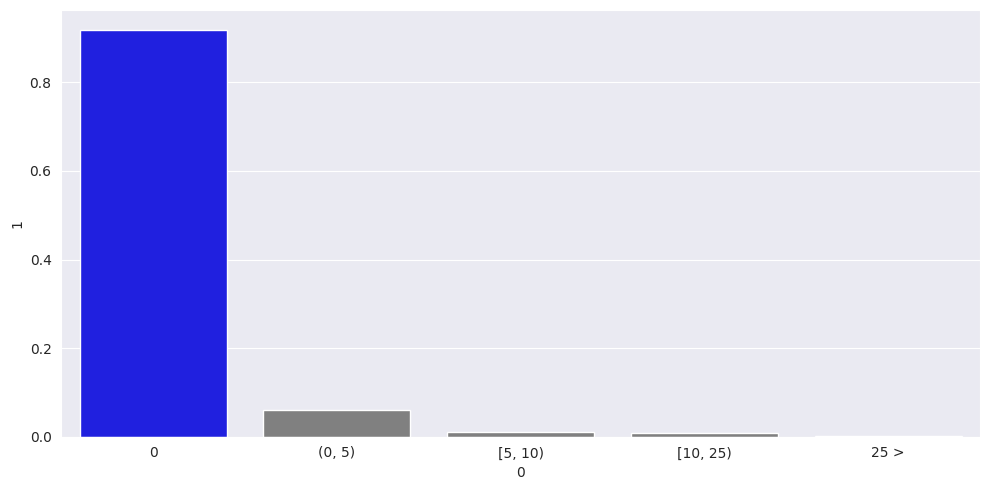

In [168]:
def discretize_vote(vote):
    if 0 < vote < 5:
        return "(0, 5)"
    if 5 <= vote < 10:
        return "[5, 10)"
    if 10 <= vote < 25:
        return "[10, 25)"
    if 25 <= vote:
        return "25 >"

    return "0"


vote_df = pd.DataFrame(Counter(corsair_df['vote'].apply(discretize_vote).tolist()).most_common())
vote_df[1] = vote_df[1] / vote_df[1].sum()

vote_df["color"] = vote_df[1].apply(
    lambda x: "blue" if x == vote_df[1].max() else "gray"
)

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=vote_df[0], y=vote_df[1], ax=ax, palette=vote_df["color"])
fig.tight_layout()

### Review Summary & Text

##### Summary

In [169]:
text_lengths = corsair_df["summary"].str.len()
mean_length = np.round(np.mean(text_lengths))
print("Mean Review Summary Length:", mean_length, "characters\n")

print("Some Review Summary Examples:\n")

k = 5
for x in corsair_df["summary"]:
    if k < 0:
        break
    else:
        print(x + '\n')
        k = k - 1

Mean Review Summary Length: 25.0 characters

Some Review Summary Examples:

good product, I recommend it

nice

Just what you want from a PSU/ I have had good look with Corsair PSU so always come back to ...

Great RAM.

Keeps my case nice and cool with a little bit of bling

One Star



In [170]:
def discretize_length(length, limits):
    if length < limits[0]:
        return f"< {limits[0]}"

    k = 0
    while length < limits[-1]:
        if limits[k] <= length < limits[k + 1]:
            return f"{limits[k]} - {limits[k + 1]}"
        k = k + 1

    return f">= {limits[-1]}"

def get_lengths_category(limits):
    cats = [f"< {limits[0]}"]

    for i in range(len(limits) - 1):
        cats.append(f"{limits[i]} - {limits[i + 1]}")

    cats.append(f">= {limits[-1]}")

    return pd.CategoricalDtype(cats, ordered=True)

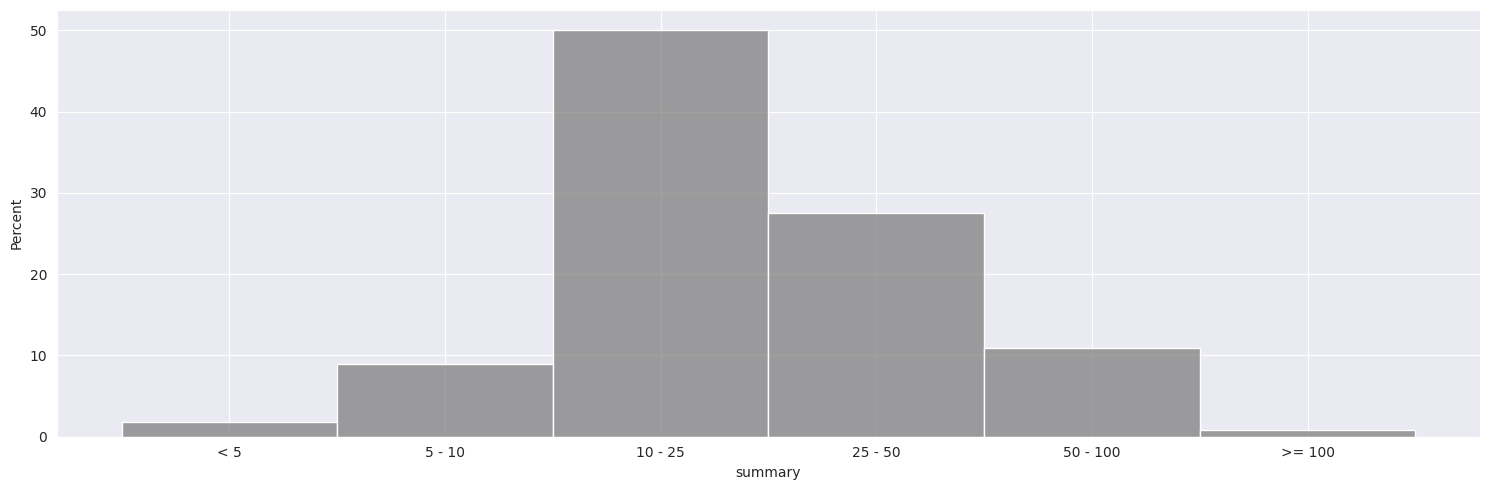

In [171]:
limits = [5, 10, 25, 50, 100]

fig, ax = plt.subplots(figsize=(15, 5))
lengths = corsair_df["summary"].str.len().apply(lambda x: discretize_length(x, limits))
lengths = lengths.astype(get_lengths_category(limits))
sns.histplot(x=lengths, stat="percent", ax=ax, color='gray')

fig.tight_layout()

##### Text

In [172]:
text_lengths = corsair_df["text"].str.len()
mean_length = np.round(np.mean(text_lengths))
print("Mean Review Text Length:", mean_length, "characters\n")

print("Some Review Text Examples:\n")

k = 5
for x in corsair_df["text"]:
    if k < 0:
        break
    else:
        print(x + '\n')
        k = k - 1

Mean Review Text Length: 275.0 characters

Some Review Text Examples:

good product, I recommend it, that card looks good, to put my laptop worked properly. the price is very good in relation to quality.

great fans. nice lights.

Plugged it in and it powered up. Just what you want from a PSU/ I have had good look with Corsair PSU so always come back to them.

Works! Need I say more? Great RAM.

Keeps my case nice and cool with a little bit of bling. Perfect for gaming PC. The pics show true colors, love seeing them in a dark room.

Don't purchase it's not worth $50.00



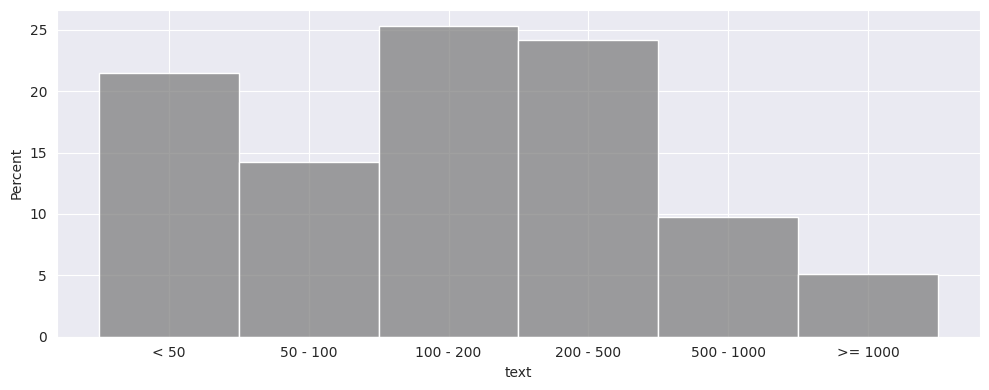

In [173]:
limits = [50, 100, 200, 500, 1000]

fig, ax = plt.subplots(figsize=(10, 4))
lengths = text_lengths.apply(lambda x: discretize_length(x, limits))
lengths = lengths.astype(get_lengths_category(limits))
sns.histplot(lengths, stat="percent", ax=ax, color='gray')
#ax.set_xlim([0, np.max(text_lengths)])
fig.tight_layout()